In [15]:
import os
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import time, datetime
import copy
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets
from resnet_pytorch import ResNet 
import random
from PIL import Image
from torch.nn import functional as F

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#effi
from efficientnet_pytorch import EfficientNet


# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트
#font_name = fm.FontProperties(fname="/usr/share/fonts/nanum/NanumGothicExtraBold.ttf").get_name()
#plt.rc('font', family=font_name)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
batch_size = 32
input_path = "/home/piai/바탕화면/hanja_crop_50/new50/output_crop/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [17]:
test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        normalize
                                    ])
test_dataset = datasets.ImageFolder(input_path + 'test', test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [18]:
classes = test_dataset.classes
len(classes)

4893

In [19]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes = 4893).to(device)
model.load_state_dict(torch.load('/home/piai/바탕화면/hanja_crop_50/new50/weights/best_weights_effi_re_ver.pth'))

Loaded pretrained weights for efficientnet-b3


<All keys matched successfully>

## Test the Model

In [20]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        #print(labels)
        #print(predicted)
        # correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 95.74085235595703 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


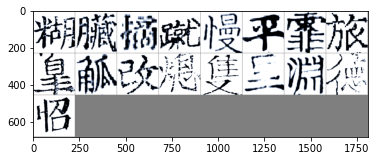

In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# # 학습용 이미지를 무작위로 가져오기
# dataiter = iter(dataloaders['train'])
# images, labels = dataiter.next()
import torchvision
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

In [22]:
[classes[labels[j]] for j in range(17)]

['4995',
 '6258',
 '6372',
 '1983',
 '8807',
 '1885',
 '4082',
 '735',
 '3485',
 '8370',
 '2680',
 '1183',
 '523',
 '7646',
 '7371',
 '6518',
 '767']

## Image 출력

In [23]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [24]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [25]:
images, labels, probs = get_predictions(model, test_loader)
pred_labels = torch.argmax(probs, 1)

In [26]:
img_list = random.sample(range(len(images)), 30)
img_list[:5]

[7521, 8648, 21354, 2629, 22087]

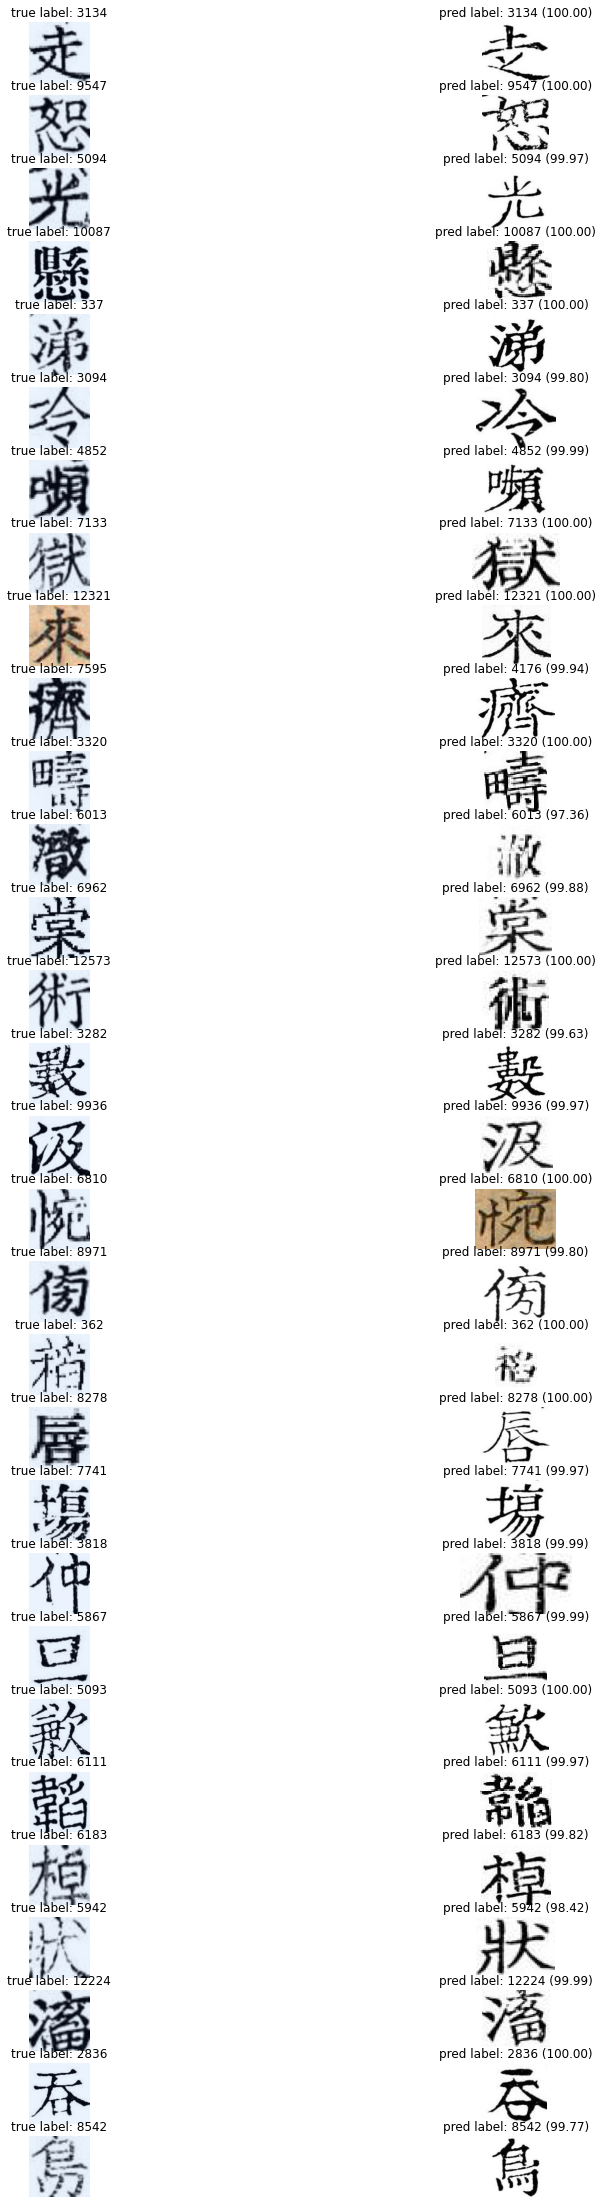

In [27]:
fig, axs = plt.subplots(len(img_list), 2, figsize=(15, 40))

j = 0
for idx in img_list:
    ax1 = axs[j, 0]
    ax2 = axs[j, 1]

    
    true_label = classes[labels[idx]]
    pred_prob, pred_label = max(probs[idx]), classes[pred_labels[idx]]

    img1 = images[idx].permute(1, 2, 0)    
    if normalize:
        img1 = normalize_image(img1)
        
    img_path2 = '/home/piai/바탕화면/hanja_crop_50/new50/output_crop/train/{}/'.format(pred_label)
    img_name2 = img_path2 + os.listdir(img_path2)[0]
    img2 = Image.open(img_name2).convert('RGB')
    img2  = np.array(img2)

        
    ax1.imshow(img1)
    ax1.set_title(f'true label: {true_label}')
    
    ax2.imshow(img2)
    ax2.set_title(f'pred label: {pred_label} ({pred_prob*100:.2f})')
    
    
    ax1.axis('off')
    ax2.axis('off')
    j+=1